In [1]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import os
from crashpy.utilities import crashMemMap
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
def get_bin_widths():
    h = 6.62607004e-34
    e = 1.60217662e-19
    freq_path = '/ptmp/mpa/mglatzle/TNG_f_esc/fid2/BB_T1d4_L2d38_r67_DUST.ps'
    freq = np.loadtxt(freq_path, skiprows=1)[1:,0]
    bin_widths = []
    centroids = []
    for i in range(len(freq)-1):
        bin_widths.append(freq[i+1]-freq[i])
        centroids.append(freq[i]/2+freq[i+1]/2)
    energies = np.array(centroids)*h/e    
    return (np.array(bin_widths)*h/e, energies)

In [41]:
def get_tot_photons(df,IDs=None,emitted=True):
    if IDs==None:
        IDs = df.index.values
    tot_photons = np.zeros(df.loc[IDs[0]]['emitted_photons'].shape[0])
    for ID in IDs:
        if emitted:
            photons = df.loc[ID]['emitted_photons']/df.loc[ID]['n_iterations']
        else:
            photons = df.loc[ID]['escaped_photons']/df.loc[ID]['n_iterations']
        photons_cum = photons.sum(axis=1)
        if np.isnan(np.sum(photons_cum)):
            continue
        else:
            tot_photons += photons_cum
    
    return tot_photons

In [4]:
def get_spectrum(df, IDs=None, emitted=True):
    bin_widths, energies = get_bin_widths()
    tot_photons = get_tot_photons(df, IDs, emitted)
    tot_photons_norm = tot_photons/tot_photons.sum()
    spectrum = tot_photons_norm/bin_widths
    return (energies, bin_widths, spectrum)

### Function which plots the average or median frequency dependent escape fraction:
- **dataframes**: List of dataframes for which the escape fraction needs to be analysed
- **mode**: Do you want to take the mean or the average over the halo escape fractions
- **labels**: Labels for the graphs, by default they will be named 'dataframe n' where n is the number of the dataframe as it appears in the dataframes list

In [42]:
def freq_fesc(dataframes, mode='mean', labels=None, savename=None, residual=False, save=False):
    plt.rcParams["figure.figsize"] = (30,20)
    
    linewidth = 6
    vert_width = 3
    labelsize = 65
    axes_width = 3
    ticksize = 80
    major_tick_length = 16
    major_tick_width = 4
    minor_tick_length = 8
    minor_tick_width = 3
    legendsize = 50
    hI_ion = 13.6
    heI_ion = 24.6
    heII_ion = 54.4
    vert_width=3
    x_label = r'$E[\mathrm{eV}]$'
    
    if residual:
        y_label = r'$\frac{f_{\mathrm{esc, no dust}}-f_{\mathrm{dust}}}{f_{\mathrm{esc, no dust}}}$'
    else:
        y_label = r'$\langle f_{\mathrm{esc}} \rangle$'
    #Set natural constants to convert photon frequency to energy in eV
    h = 6.62607004e-34
    e = 1.60217662e-19
    if labels == None:
        labels=[]
        for i in range(len(dataframes)):
            labels.append(f'dataframe {i+1}')

    values_array = []
    for i, dataframe in enumerate(dataframes):
        energies = dataframe.iloc[0]['frequencies']*h/e

        per_freq_data = np.vstack(dataframe.loc[:,'per_freq'].to_numpy())
        error = np.std(per_freq_data, axis=0)/np.sqrt(len(per_freq_data))

        if mode == 'mean':
            values = np.mean(per_freq_data, axis=0)
        elif mode == 'median':
            values = np.median(per_freq_data, axis=0)
        else:
            raise ValueError('The possible modes are "mean" and "median"')
        #plt.ylim(0,0.35)
        if residual:
            values_array.append(values)
        else:
            plt.errorbar(energies, values, yerr=error, linewidth=5, elinewidth=1, capsize=10, label=str(labels[i]))
    
    if residual:
        plt.plot(energies, (values_array[1]-values_array[0])/values_array[0], linewidth = linewidth)
    
    vert_color='black' 
    vert_style = '--'
    plt.axvline(x=hI_ion, linewidth=vert_width, color=vert_color, linestyle=vert_style)
    plt.axvline(x=heI_ion, linewidth=vert_width, color=vert_color, linestyle=vert_style)
    plt.axvline(x=heII_ion, linewidth=vert_width, color=vert_color, linestyle=vert_style)
    plt.xlabel(x_label, fontsize = labelsize)
    plt.ylabel(y_label, fontsize = labelsize)
    
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=ticksize) 
    plt.rc('ytick', labelsize=ticksize) 
    plt.tick_params(length=major_tick_length, width=major_tick_width)
    plt.tick_params(length=minor_tick_length, width=minor_tick_width, which='minor')
    plt.legend(fontsize=legendsize)
    if save:
        if savename == None:
            plt.savefig(f'/u/ivkos/analysis/plots/freq_fesc.pdf', bbox_inches = 'tight', pad_inches = 0)
        else:
            plt.savefig(f'/u/ivkos/analysis/plots/{savename}.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    return 

In [43]:
def get_wavelength(energy):
    h = 6.62607004e-34
    e = 1.60217662e-19
    c = 299792458.
    to_ang = 1e10
    return h*c/energy/e*to_ang

def get_energy(wavelength):
    h = 6.62607004e-34
    e = 1.60217662e-19
    c = 299792458.
    to_ang = 1e10
    return h*c/wavelength/e/to_ang

In [44]:
def plot_multiple_spectra_comparison(dfs, colors=None, labels=None, tag='', save=False, top_title=False):
    
    hI_ion = 13.6
    heI_ion = 24.6
    heII_ion = 54.4
    
    labelsize = 50
    legendsize = 25
    legend_loc = 'lower left'
    axis_width = 4
    vert_width = 2
    vert_color='black' 
    vert_style = '--'
    tick_size_major = 16
    tick_size_minor = 8
    tick_width_major = 4
    tick_width_minor = 3
    tick_label_size = 45
    figsize_x = 30
    figsize_y = 10
    ticks = [20, 50, 100]
    ticks_upper = [1e3, 3e2, 1e2]
    x_axis_label = '$E_\gamma[\mathrm{eV}]$'
    y_axis_label = '$P(\gamma)$'
    sec_x_axis_label = r'$\lambda [\mathrm{\AA}]$'
    
    if colors==None:
        colors=['b','g','r', 'c','m','y']
    if labels==None:
        labels=[x for x in range(len(dfs))]
    for i, df in enumerate(dfs):
        energies, widths, spec_em = get_spectrum(df, IDs=None, emitted=True)
        energies, widths, spec_es = get_spectrum(df, IDs=None, emitted=False)
        
        ax = plt.gca()
        ax.plot(energies, spec_em, label=f'{labels[i]} emitted', linewidth=3, color=colors[i])
        ax.plot(energies, spec_es, label=f'{labels[i]} escaped', linewidth=3, color=colors[i], linestyle='dashed')
    
    ax.axvline(x=hI_ion, linewidth=vert_width, color=vert_color, linestyle=vert_style)
    ax.axvline(x=heI_ion, linewidth=vert_width, color=vert_color, linestyle=vert_style)
    ax.axvline(x=heII_ion, linewidth=vert_width, color=vert_color, linestyle=vert_style)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    secax = ax.secondary_xaxis('top', functions=(get_wavelength, get_energy))
    if top_title:
        secax.set_xlabel(sec_x_axis_label, fontsize=labelsize)
    secax.tick_params(length=tick_size_major, width=tick_width_major)
    secax.tick_params(length=tick_size_minor, width=tick_width_minor, which='minor')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)

    ax.set_xlabel(x_axis_label, fontsize=labelsize)
    ax.set_ylabel(y_axis_label, fontsize=labelsize)
    ax.legend(fontsize=legendsize, loc=legend_loc)
    
    plt.rcParams["figure.figsize"] = (figsize_x,figsize_y)
    plt.rc('axes', linewidth=axis_width)
    plt.tick_params(length=tick_size_major, width=tick_width_major)
    plt.tick_params(length=tick_size_minor, width=tick_width_minor, which='minor')
    
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/spectra_comparison_{tag}.pdf', bbox_inches = 'tight')

    return

In [45]:
def plot_spectra_comparison(df, mode='mean', IDs=None, save=False, top_title=False):
    energies, widths, spec_em = get_spectrum(df, IDs=IDs, emitted=True)
    energies, widths, spec_es = get_spectrum(df, IDs=IDs, emitted=False)
    
    hI_ion = 13.6
    heI_ion = 24.6
    heII_ion = 54.4
    
    labelsize = 50
    legendsize = 35
    axis_width = 4
    vert_width=3
    linewidth = 4
    tick_size_major = 16
    tick_size_minor = 8
    tick_width_major = 4
    tick_width_minor = 3
    tick_label_size = 35
    figsize_x = 20
    figsize_y = 12
    ticks = [20, 50, 100]
    ticks_upper = [1e3, 3e2, 1e2]
    
    ax = plt.gca()
    ax.plot(energies, spec_em, label='emitted spectrum', linewidth=linewidth)
    ax.plot(energies, spec_es, label='escaped spectrum', linewidth=linewidth)
    vert_color='black' 
    vert_style = '--'
    ax.axvline(x=hI_ion, linewidth=vert_width, color=vert_color, linestyle=vert_style)
    ax.axvline(x=heI_ion, linewidth=vert_width, color=vert_color, linestyle=vert_style)
    ax.axvline(x=heII_ion, linewidth=vert_width, color=vert_color, linestyle=vert_style)

    secax = ax.secondary_xaxis('top', functions=(get_wavelength, get_energy))

    if top_title:
        secax.set_xlabel(r'$\lambda [\mathrm{\AA}]$', fontsize=labelsize)
    secax.tick_params(length=tick_size_major, width=tick_width_major)
    secax.tick_params(length=tick_size_minor, width=tick_width_minor, which='minor')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    
    secax.set_xticks(ticks_upper)
    secax.set_xticklabels(ticks_upper)

    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    secax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.rc('xtick', labelsize=tick_label_size) 
    plt.rc('ytick', labelsize=tick_label_size) 
    ax.set_xlabel('$E_\gamma[\mathrm{eV}]$', fontsize=labelsize)
    ax.set_ylabel('$P(\gamma)$', fontsize=labelsize)
    ax.legend(fontsize=legendsize)
    plt.rcParams["figure.figsize"] = (figsize_x,figsize_y)
    plt.rc('axes', linewidth=axis_width)
    plt.tick_params(length=tick_size_major, width=tick_width_major)
    plt.tick_params(length=tick_size_minor, width=tick_width_minor, which='minor')
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/spectra.pdf', bbox_inches = 'tight')

    return

In [46]:
def update_df(df, h=0.6774):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e10/h
    return

In [39]:
df_dust = pd.read_pickle('dfs/fid2d.pickle')
df_no_dust_full = pd.read_pickle('dfs/fid2.pickle')
update_df(df_dust)
update_df(df_no_dust)

In [10]:
df = pd.read_pickle('dfs/esc_analysis.pickle')
update_df(df)

In [40]:
df_no_dust =  df_no_dust_full.merge(df_dust[['ID','z']], on=['ID','z'], how='inner')

In [54]:
df = df.drop([6676, 6713,7507])

In [37]:
filt_f_esc = df.f_esc > 0.1
filt_f_esc_small = df.f_esc < 0.01
filt_star = df.StarMass > 5e7
filt_star_small = df.StarMass < 5e6
dfs_1=[df[filt_f_esc],df[filt_f_esc_small]]
dfs_2=[df[filt_star], df[filt_star_small]]
labels_1 = [r'$f_\mathrm{esc}>0.1$',r'$f_\mathrm{esc}<0.01$']
labels_2 = [r'$M_\mathrm{star}>10^8$',r'$M_\mathrm{star}<5\times 10^6$']
tag_1 = 'esc'
tag_2 = 'mass'

In [18]:
freq_fesc([df_dust, df_no_dust], mode='mean', savename='dust_no_dust', labels=['dust', 'no dust'], residual=False, save=True)

NameError: name 'df_dust' is not defined

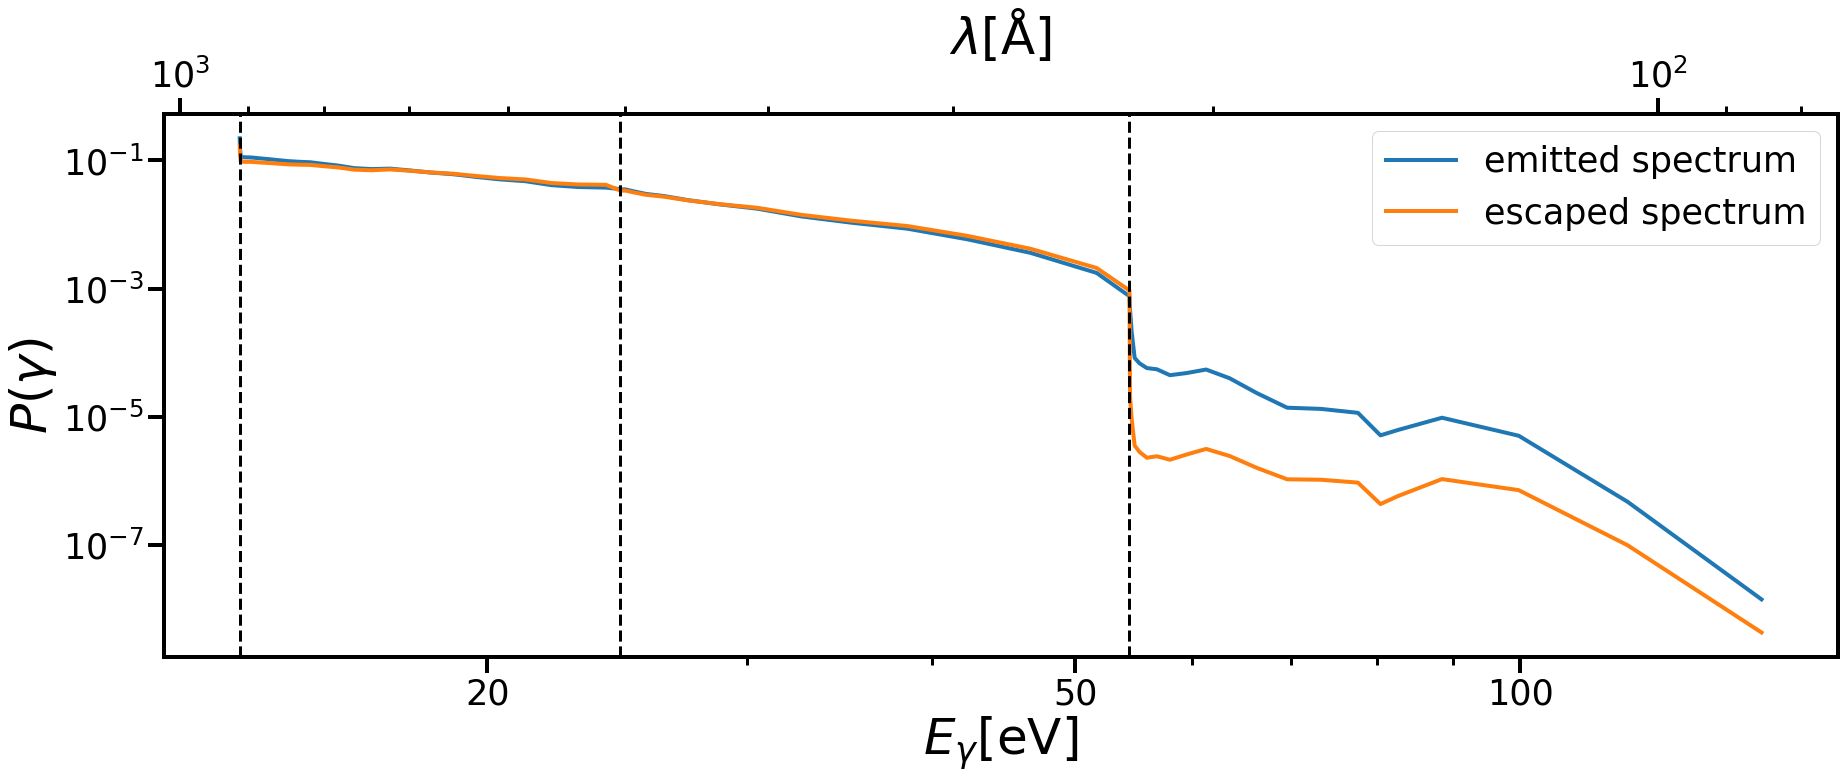

In [50]:
plot_spectra_comparison(df, save=True, top_title=True)

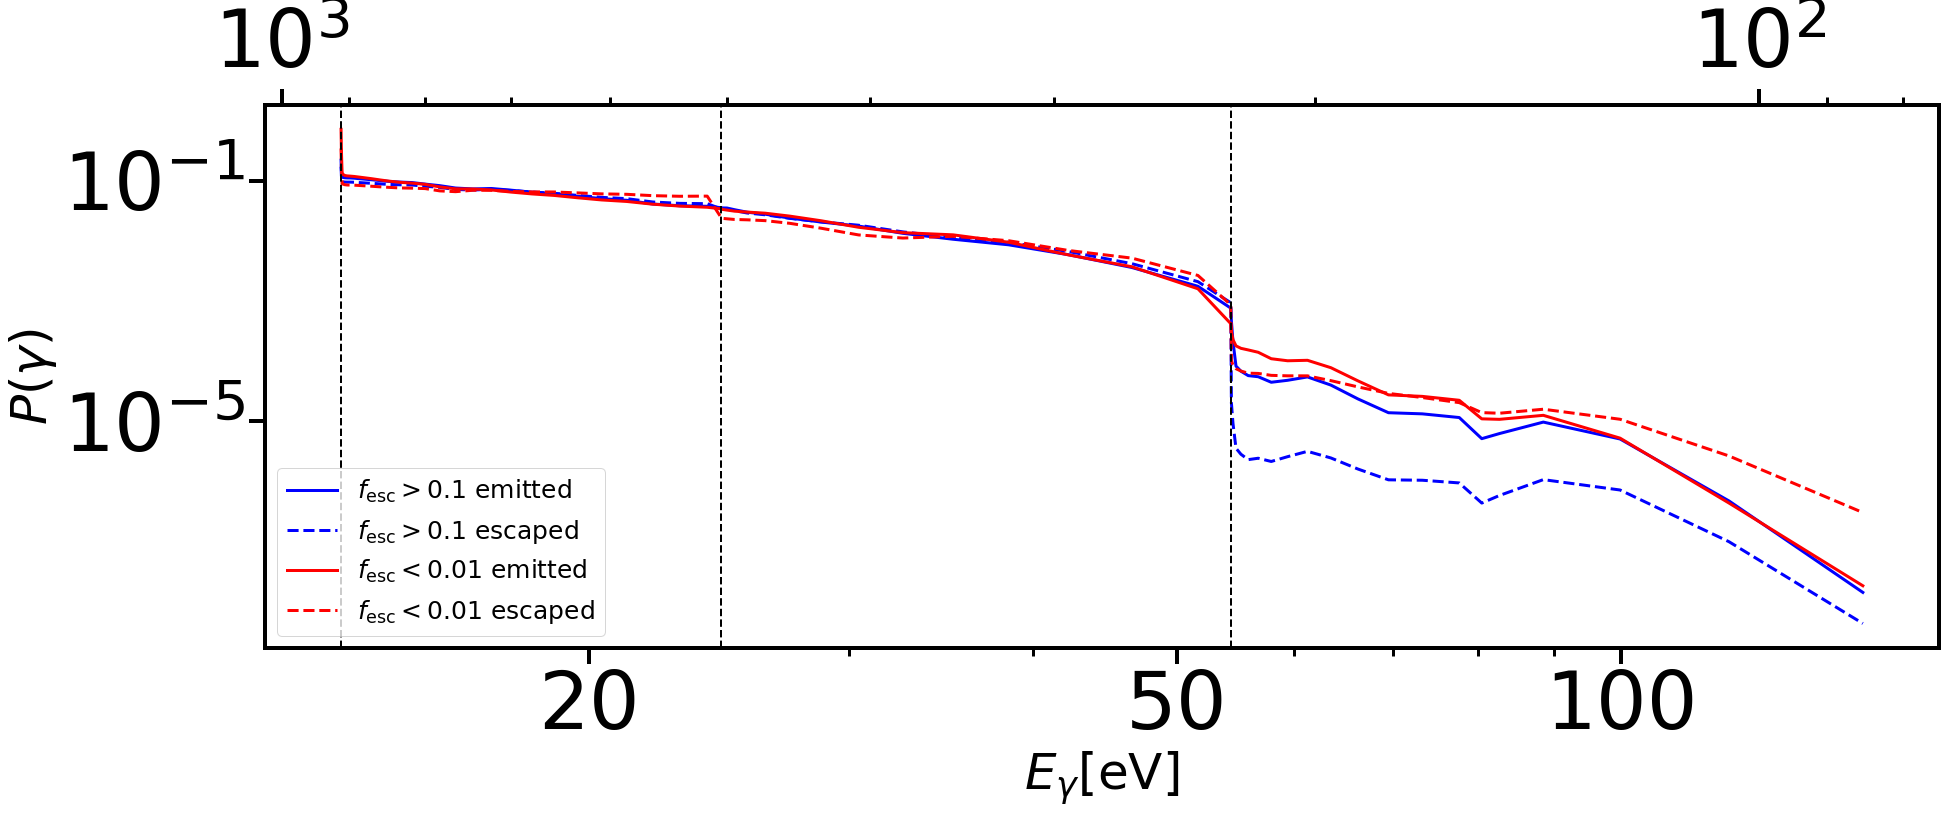

In [62]:
plot_multiple_spectra_comparison(dfs_1, colors=['blue', 'red'], labels=labels_1, tag=tag_1, save=True, top_title=False)

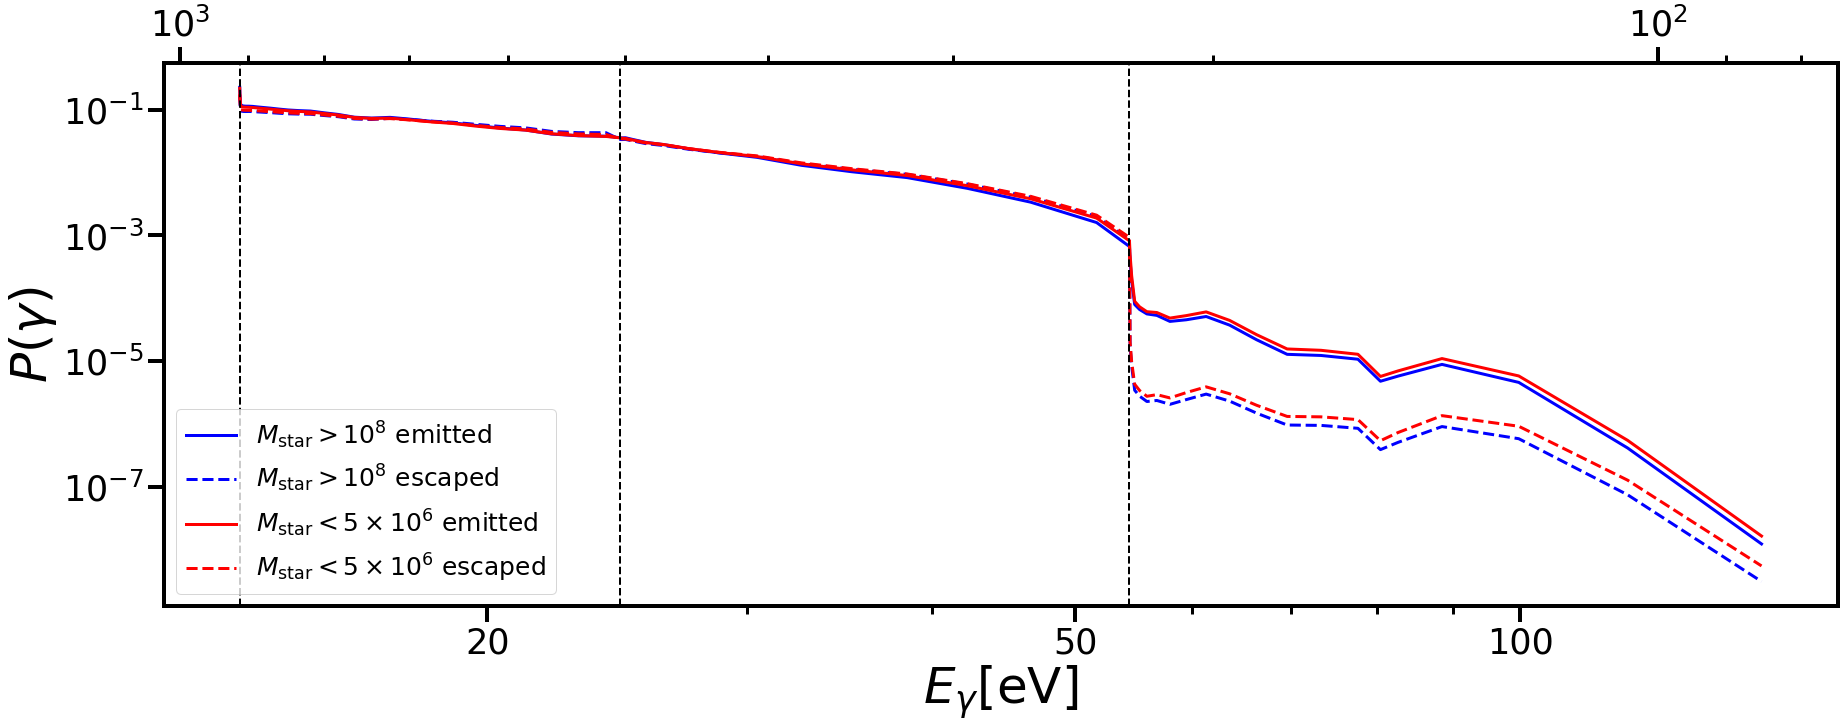

In [39]:
plot_multiple_spectra_comparison(dfs_2, colors=['blue', 'red'], labels=labels_2, tag=tag_2, save=True)

In [59]:
df_6 = df[df.z==6]
df_8 = df[df.z==8]
#df_8 = df_8.drop([6676, 6713,7507])
df_10 = df[df.z==10]
df_10 = df_10.drop([7024,6340])
dfs_z=[df_6, df_8, df_10]
labels = ['z=6','z=8','z=10']

In [58]:
df_10[df_10['ID']==6419].ID

6340    6419
Name: ID, dtype: int64

In [39]:
per_freq_data = np.vstack(df_8.loc[:,'per_freq'].to_numpy())

In [18]:
len(df_6.loc[2013].per_freq)

65

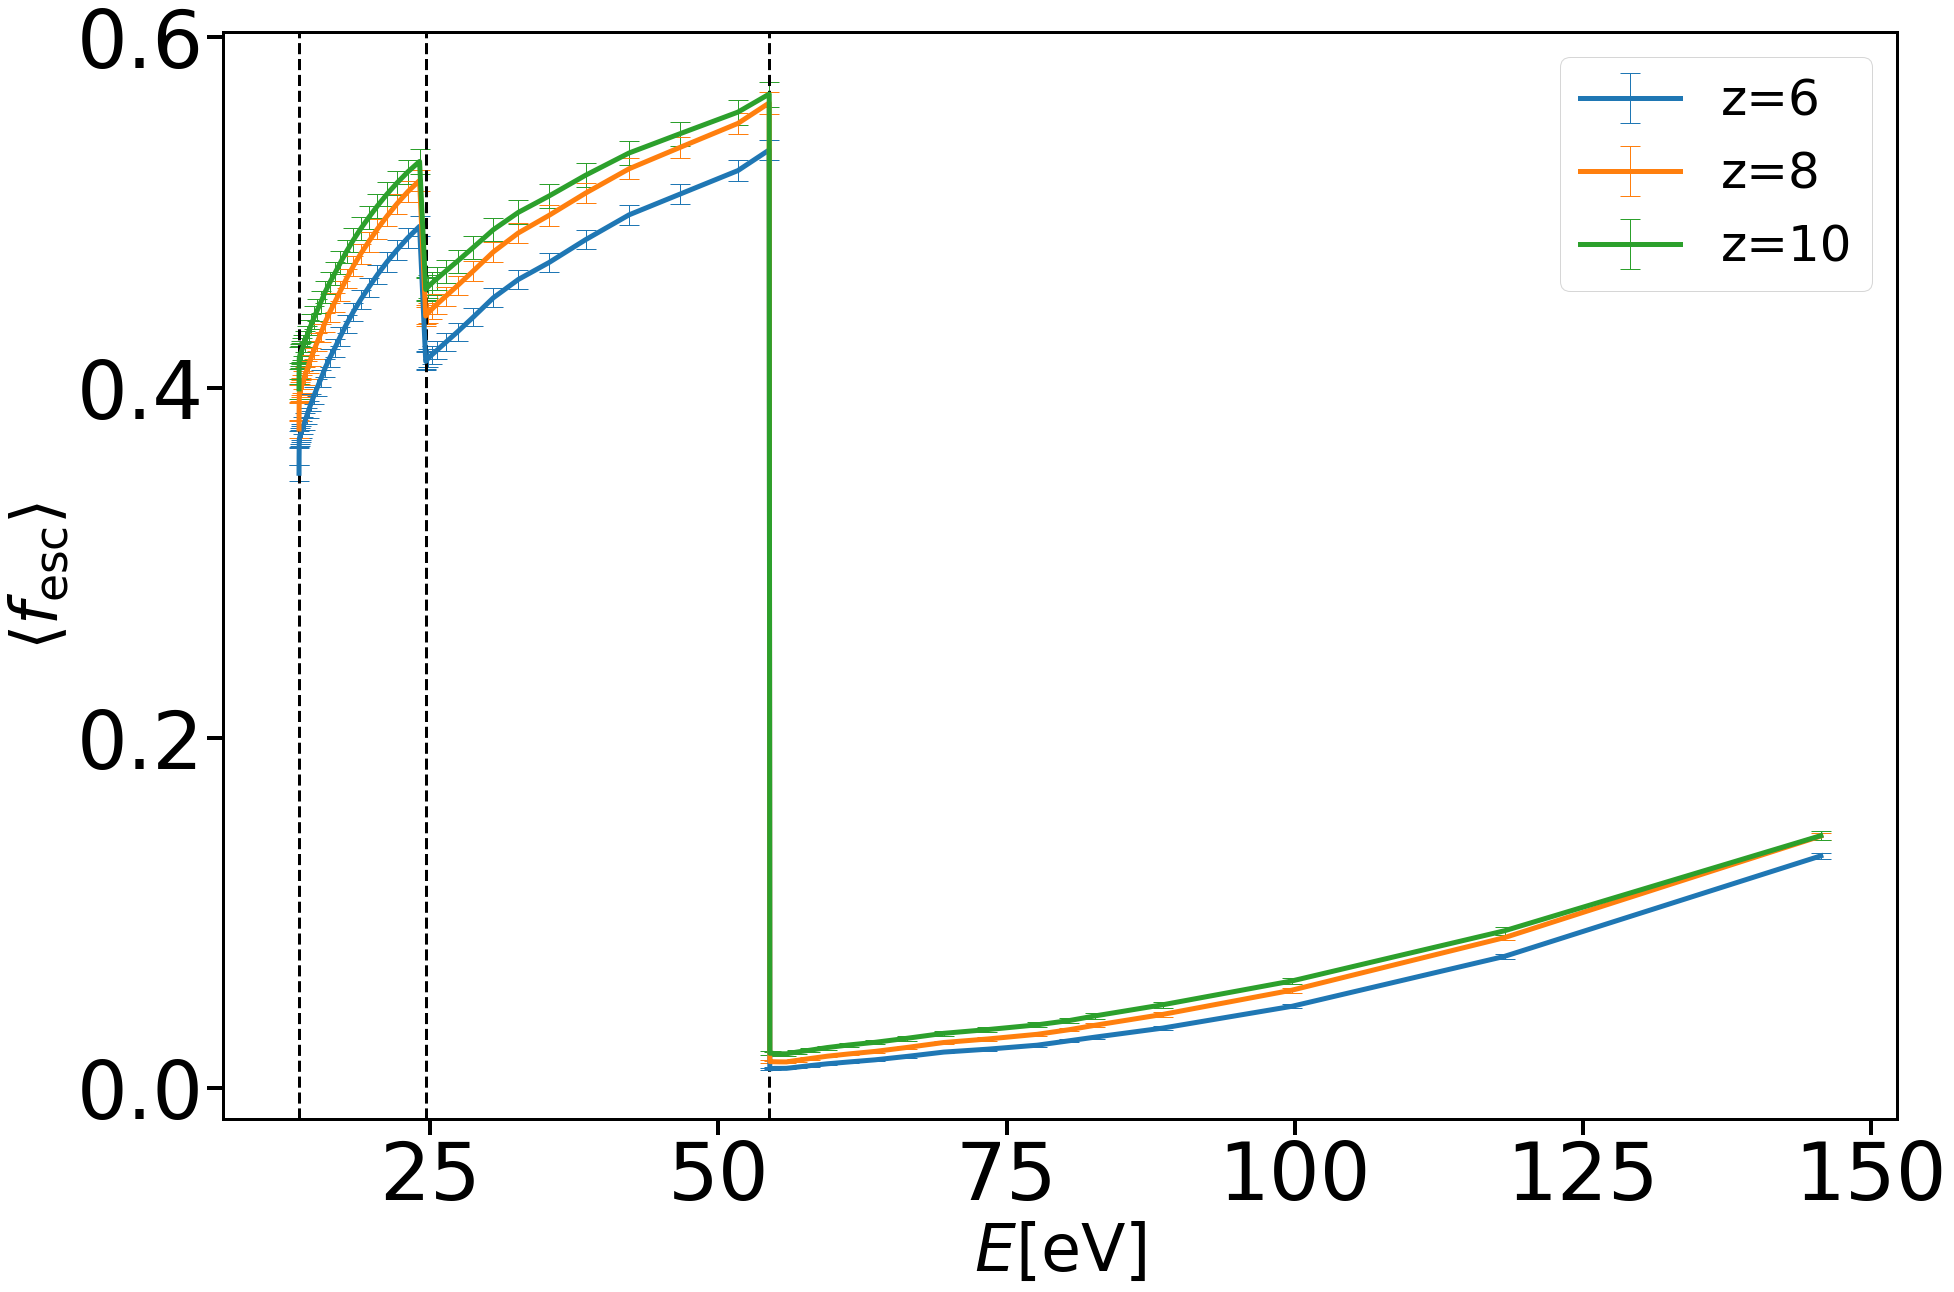

In [60]:
freq_fesc(dfs_z, mode='mean', labels=labels, save=True)

In [30]:
import scipy.integrate as integrate 
import numpy as np
from matplotlib import pyplot as plt

In [37]:
def integrand(a):
    a_eq = 3600
    R = 3*a_eq*a
    c_s = 1/np.sqrt(3*(1+R))
    dt_da = 1/(a_eq*np.sqrt(a**(-4)+a**(-3)))
    integrand = c_s/a*dt_da
    return integrand

In [38]:
x = np.linspace(0, 1/1080, 100)
y = integrand(x)

<ipython-input-37-dcaaf1cd31fe>:5: RuntimeWarning: divide by zero encountered in power
  dt_da = 1/(a_eq*np.sqrt(a**(-4)+a**(-3)))
<ipython-input-37-dcaaf1cd31fe>:6: RuntimeWarning: divide by zero encountered in true_divide
  integrand = c_s/a*dt_da
<ipython-input-37-dcaaf1cd31fe>:6: RuntimeWarning: invalid value encountered in multiply
  integrand = c_s/a*dt_da


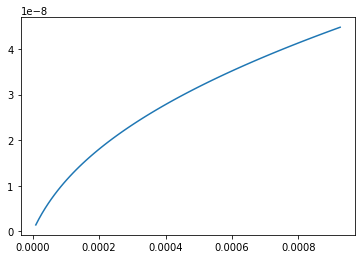

In [39]:
plt.plot(x,y)

In [43]:
approx,_ = integrate.quad(integrand,1/3600,1/1080)
truth,_ = integrate.quad(integrand,0,1/1080)

In [78]:
df['Q0']

0       7.688735e+50
1       3.544364e+52
2       5.984002e+50
3       5.915512e+52
4       3.360591e+52
            ...     
9547    3.424150e+52
9548    2.234372e+52
9549    3.691784e+52
9550    1.604101e+49
9551    5.349159e+51
Name: Q0, Length: 9549, dtype: float64

(0.001, 10.0)

(1e+50, 1e+55)

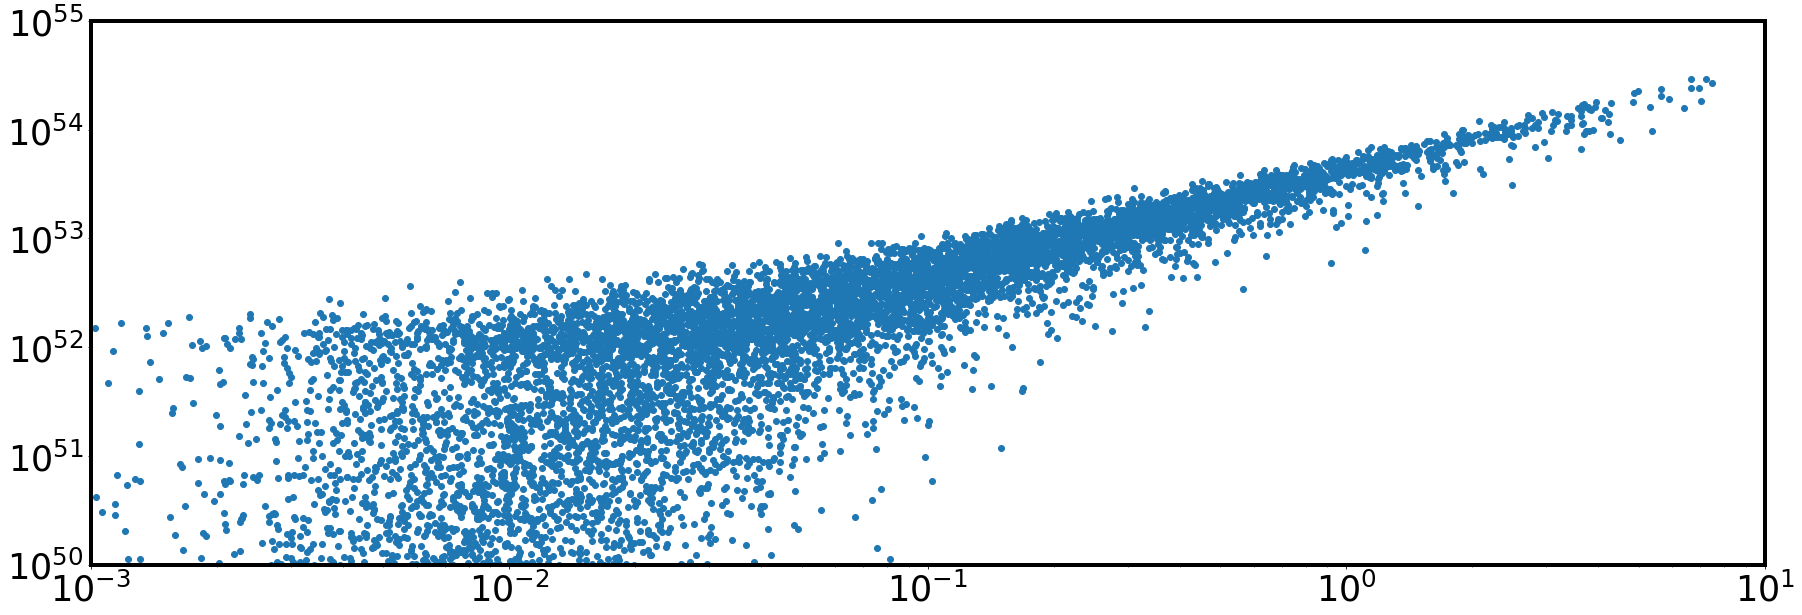

In [90]:
plt.scatter(df['SFR'], df['Q0'])
plt.xscale('log')
plt.xlim(1e-3,1e1)
plt.yscale('log')
plt.ylim(1e50, 1e55)
plt.rcParams["figure.figsize"] = (30,20)

In [104]:
df.columns

Index(['ID', 'z', 'HaloMass', 'Metallicity', 'GasMetallicity', 'FractionStars',
       'FractionGas', 'GasMassGrid', 'DustMass', 'Q0', 'HaloRadii', 'f_esc',
       'f_esc_0_2', 'Temperature', 'xHII', 'xHeII', 'xHeIII', 'GridSize',
       'BHMass', 'BHGrowth', 'SFR', 'density', 'clumping', 'per_freq',
       'per_source', 'emitted_photons', 'escaped_photons', 'frequencies',
       'n_iterations', 'per_freq_0_2', 'per_source_0_2', 'emitted_photons_0_2',
       'escaped_photons_0_2', 'frequencies_0_2', 'n_iterations_0_2',
       'Q0/HaloMass', 'R_v^3/HaloMass', 'StarMass'],
      dtype='object')

(0.001, 1.0)

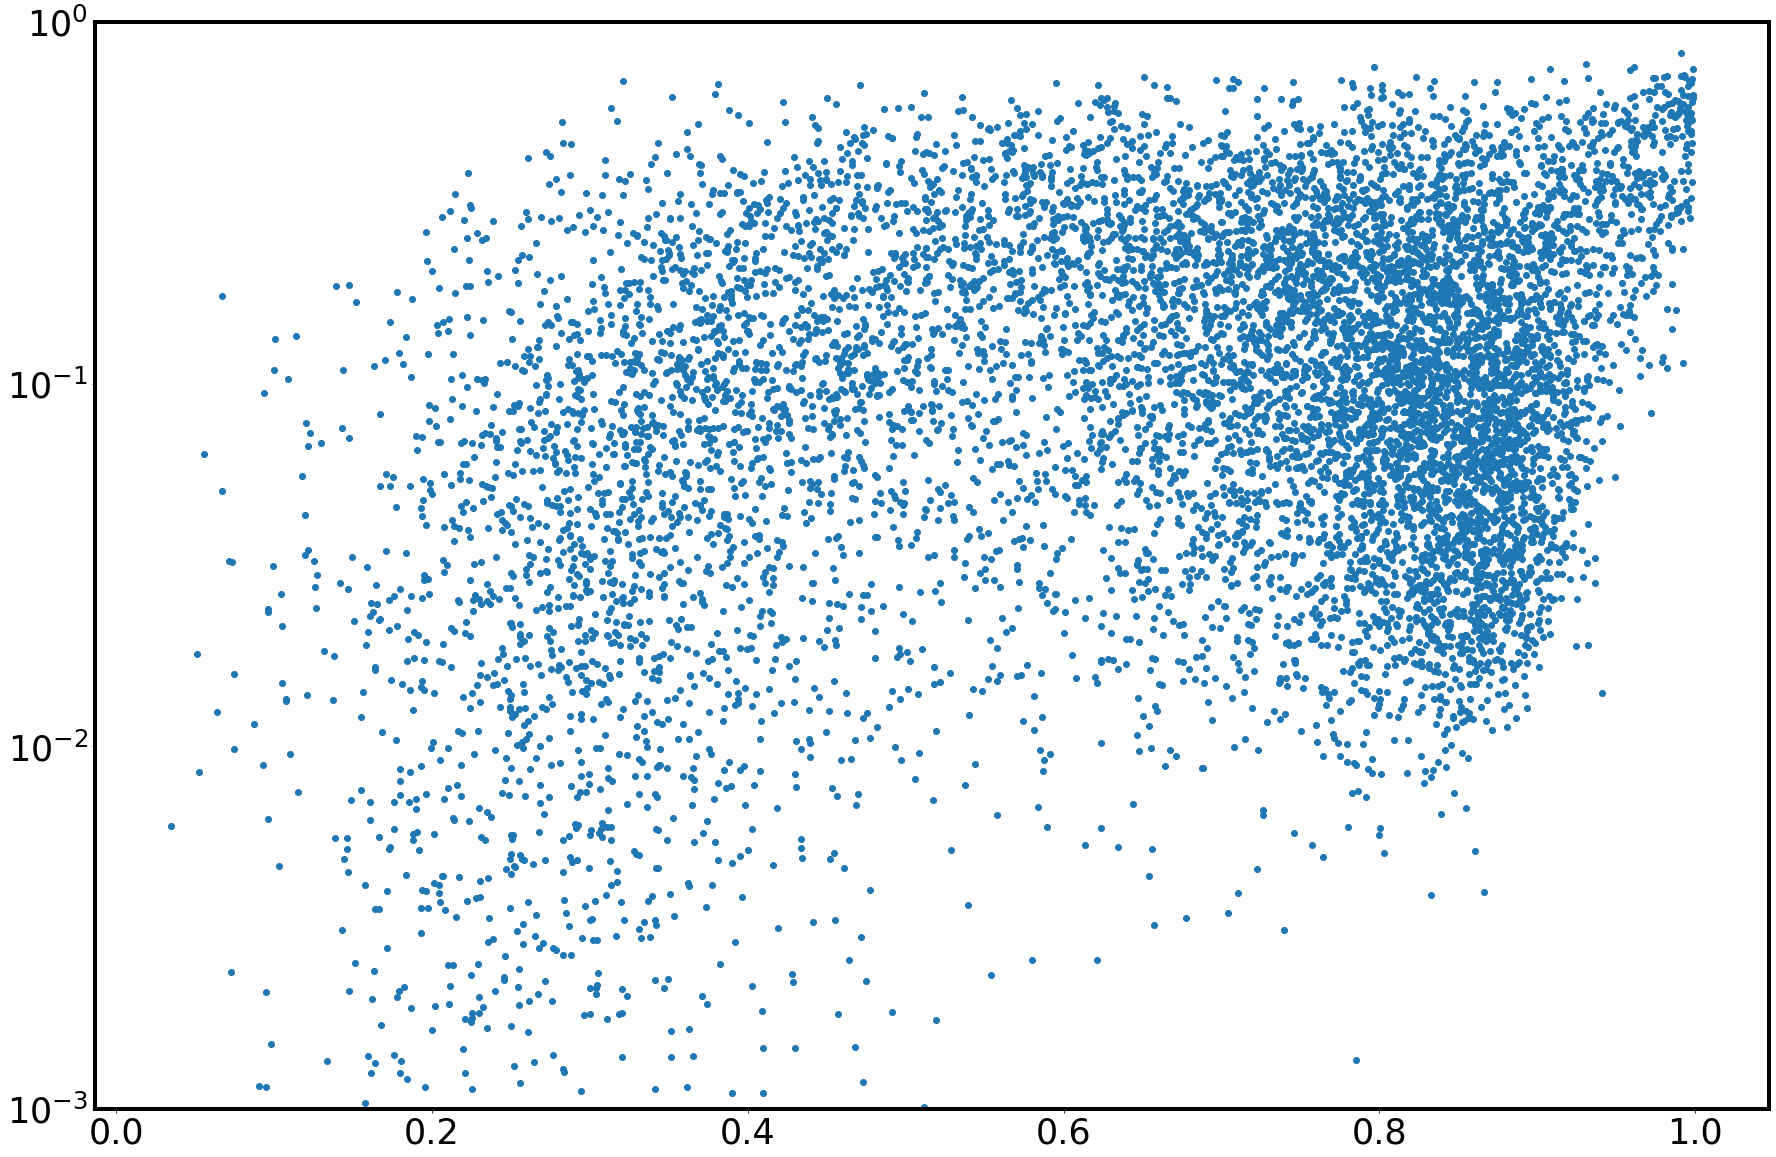

In [122]:
plt.scatter(df['xHII'], df['f_esc'])
#plt.xscale('log')
#plt.xlim(0.4,1e0)
plt.yscale('log')
plt.ylim(1e-3, 1e0)
plt.rcParams["figure.figsize"] = (30,20)